In [1]:
 # -*- coding: utf-8 -*-
#
# Author: Milan Ondrasovic <milan.ondrasovic@gmail.com>
#
# MIT License
#
# Copyright (c) 2021 Milan Ondrašovič
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import json
import pickle
import pathlib
import numpy as np
import dataclasses
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('tableau-colorblind10')
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def read_otb_report(performance_file_path):
    with open(performance_file_path, 'rt') as in_file:
        performance = json.load(in_file)

    top_level_key = next(iter(performance.keys()))
    overall_performance = performance[top_level_key]['overall']

    return overall_performance

def extract_context_from_name(tracker_name):
    tokens = tracker_name.split('_')
    batch_size = int(tokens[-2])
    epoch = int(tokens[-1])
    return batch_size, epoch

def read_otb_reports(reports_dir_path):
    data = []

    for tracker_report_dir in pathlib.Path(reports_dir_path).iterdir():
        performance_file_path = str(tracker_report_dir / "performance.json")
        overall_performance = read_otb_report(performance_file_path)

        batch_size, epoch = extract_context_from_name(tracker_report_dir.stem)

        record = {'batch_size': batch_size, 'epoch': epoch}
        stats = (
            'success_score', 'precision_score', 'success_rate', 'speed_fps')
        record.update({item: overall_performance[item] for item in stats})
        data.append(record)

    return pd.DataFrame(data)

reports_dir_path = "../reports/OTB2013"
stats = read_otb_reports(reports_dir_path)
stats

,batch_size,epoch,success_score,precision_score,success_rate,speed_fps
0,16,30,0.54289,0.72114,0.66196,41.50742
1,16,31,0.54389,0.73380,0.65774,40.01440
2,16,32,0.53872,0.72619,0.65427,39.90336
3,16,33,0.54896,0.73271,0.67321,39.57260
4,16,34,0.55029,0.73686,0.67662,41.92472
5,16,35,0.54544,0.73058,0.66072,39.87585
6,16,36,0.54701,0.73689,0.66807,41.45162
7,16,37,0.54619,0.73728,0.66892,41.93075
8,16,38,0.53677,0.72366,0.64656,39.86930
9,16,39,0.54145,0.72959,0.66447,39.60860


e:\venvs\general\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


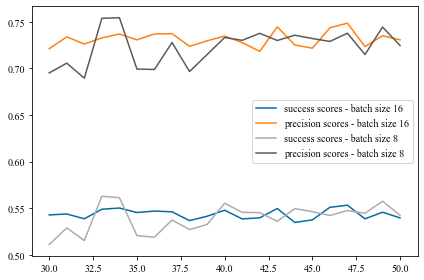

In [8]:
fig, ax = plt.subplots()

batch_sizes_groups = stats.groupby('batch_size')
for batch_size in stats['batch_size'].unique():
    bs_group = batch_sizes_groups.get_group(batch_size)

    epochs = bs_group['epoch']
    success_scores = bs_group['success_score']
    precision_scores = bs_group['precision_score']

    ax.plot(
        epochs, success_scores,
        label=f"success scores - batch size {batch_size}")
    ax.plot(
        epochs, precision_scores,
        label=f"precision scores - batch size {batch_size}")

ax.legend(loc='best')
fig.tight_layout()
fig.show()
fig.savefig("../plots_comparison.png", dpi=300)